<p style="text-align:center;">
    <font face="Georgia" size=5 color="red"><b>Import Required libraries</b></font>
</p>

In [ ]:
import os
import numpy as np
import torch
from PIL import Image
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from collections import Counter
import random
from tqdm import tqdm  
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import seaborn as sns


<p style="text-align:center;">
    <font face="Georgia" size=5 color="red"><b> load Dataset</b></font>
</p>

In [10]:
# Path to the dataset
data_dir = '/kaggle/input/cub2002011/CUB_200_2011/images'

# Load the dataset
full_dataset = datasets.ImageFolder(root=data_dir)

# Display the number of classes
num_classes = len(full_dataset.classes)
print(f'Total classes: {num_classes}')

print("______________________________________\n")

# Display the number of samples in each class
class_counts = Counter([sample[1] for sample in full_dataset.samples])
print("Number of samples in each class:\n")


for class_idx, count in class_counts.items():
    
    print(f'{full_dataset.classes[class_idx]}: {count} samples')

# Display the total number of images
total_samples = len(full_dataset.samples)

print("______________________________________")

print(f"\nTotal number of images: {total_samples}")


Total classes: 200
______________________________________

Number of samples in each class:

001.Black_footed_Albatross: 60 samples
002.Laysan_Albatross: 60 samples
003.Sooty_Albatross: 58 samples
004.Groove_billed_Ani: 60 samples
005.Crested_Auklet: 44 samples
006.Least_Auklet: 41 samples
007.Parakeet_Auklet: 53 samples
008.Rhinoceros_Auklet: 48 samples
009.Brewer_Blackbird: 60 samples
010.Red_winged_Blackbird: 60 samples
011.Rusty_Blackbird: 60 samples
012.Yellow_headed_Blackbird: 56 samples
013.Bobolink: 60 samples
014.Indigo_Bunting: 60 samples
015.Lazuli_Bunting: 58 samples
016.Painted_Bunting: 58 samples
017.Cardinal: 57 samples
018.Spotted_Catbird: 45 samples
019.Gray_Catbird: 59 samples
020.Yellow_breasted_Chat: 59 samples
021.Eastern_Towhee: 60 samples
022.Chuck_will_Widow: 56 samples
023.Brandt_Cormorant: 59 samples
024.Red_faced_Cormorant: 52 samples
025.Pelagic_Cormorant: 61 samples
026.Bronzed_Cowbird: 60 samples
027.Shiny_Cowbird: 60 samples
028.Brown_Creeper: 59 samples


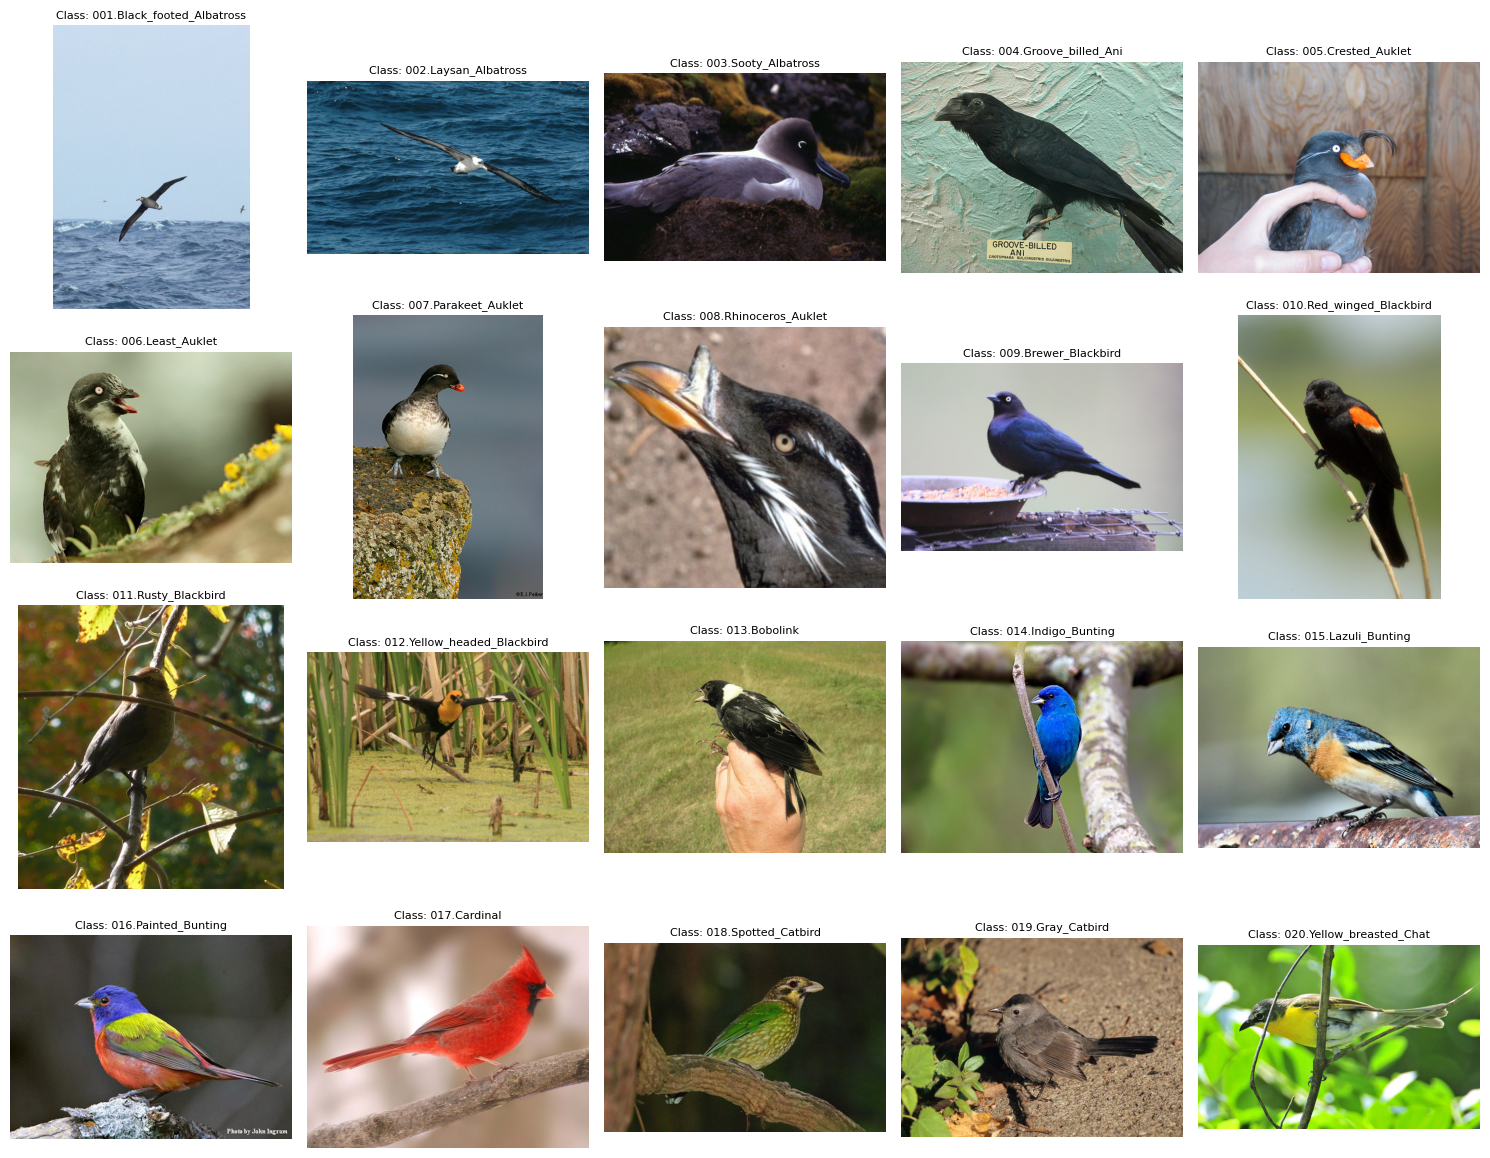

In [ ]:
# data_dir = '/kaggle/input/cub2002011/CUB_200_2011/images'

# Data preprocessing
transform = transforms.Compose([
    
    transforms.ToTensor(),          # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

# Load the dataset (folder 'images')
dataset = datasets.ImageFolder(root=data_dir, transform=transform)


# Number of classes to display 
classes_to_show = 20  

# Determine the number of subplots to display 
cols = 5  
rows = classes_to_show // cols + (classes_to_show % cols > 0)  

# Create a figure to display the images
fig, axes = plt.subplots(rows, cols, figsize=(15, 3 * rows))
axes = axes.flatten()

# Display one sample from each class
for i in range(classes_to_show):
    
    class_folder = dataset.classes[i]
    
    class_images = os.listdir(os.path.join(data_dir, class_folder))
    
    image_path = os.path.join(data_dir, class_folder, class_images[0])  
    image = Image.open(image_path)
    
    
    ax = axes[i]
    ax.imshow(image)
    ax.set_title(f'Class: {class_folder}', fontsize=8)
    ax.axis('off')  


plt.tight_layout()
plt.show()


<p style="text-align:center;">
    <font face="Georgia" size=4 color="red"><b>Dataset Processing (Image Crop ,Normalize ,Resize)</b></font>
</p><p style="text-align:center;">
    <font face="Georgia" size=4 color="red"><b> Image Crop</b></font>
</p>

In [ ]:
# Root dataset directory 
ROOT_DIR = '/kaggle/input/cub2002011/CUB_200_2011'
IMAGE_DIR = os.path.join(ROOT_DIR, 'images')
CROPPED_DIR = '/kaggle/working/cropped__images'

# Step 1: Load metadata
def load_metadata(root_dir):
    with open(os.path.join(root_dir, 'images.txt')) as f:
        id_to_path = {int(x.split()[0]): x.split()[1] for x in f}

    with open(os.path.join(root_dir, 'image_class_labels.txt')) as f:
        id_to_label = {int(x.split()[0]): int(x.split()[1]) for x in f}

    with open(os.path.join(root_dir, 'bounding_boxes.txt')) as f:
        id_to_bbox = {
            int(x.split()[0]): tuple(map(float, x.split()[1:])) for x in f
        }

    return id_to_path, id_to_label, id_to_bbox

# Step 2: Crop and save images
def crop_and_save_images(id_to_path, id_to_label, id_to_bbox, src_dir, dst_dir):
    os.makedirs(dst_dir, exist_ok=True)

    print(f" Cropping {len(id_to_path)} images...")
    for img_id in tqdm(id_to_path, desc="Processing images"):
        rel_path = id_to_path[img_id]
        label = id_to_label[img_id]
        bbox = id_to_bbox[img_id]  # (x, y, width, height)

        src_path = os.path.join(src_dir, rel_path)
        dst_path = os.path.join(dst_dir, rel_path)
        dst_folder = os.path.dirname(dst_path)
        os.makedirs(dst_folder, exist_ok=True)

        img = cv2.imread(src_path)
        if img is None:
            continue  # skip unreadable images

        x, y, w, h = bbox
        x, y, w, h = map(int, [x, y, w, h])
        crop = img[y:y+h, x:x+w]

        cv2.imwrite(dst_path, crop)



# Run all steps
id_to_path, id_to_label, id_to_bbox = load_metadata(ROOT_DIR)
crop_and_save_images(id_to_path, id_to_label, id_to_bbox, IMAGE_DIR, CROPPED_DIR)

 Cropping 11788 images...


Processing images: 100%|██████████| 11788/11788 [00:40<00:00, 290.99it/s]


<p style="text-align:center;">
    <font face="Georgia" size=4 color="red"><b>Display Crop Images</b></font>
</p>

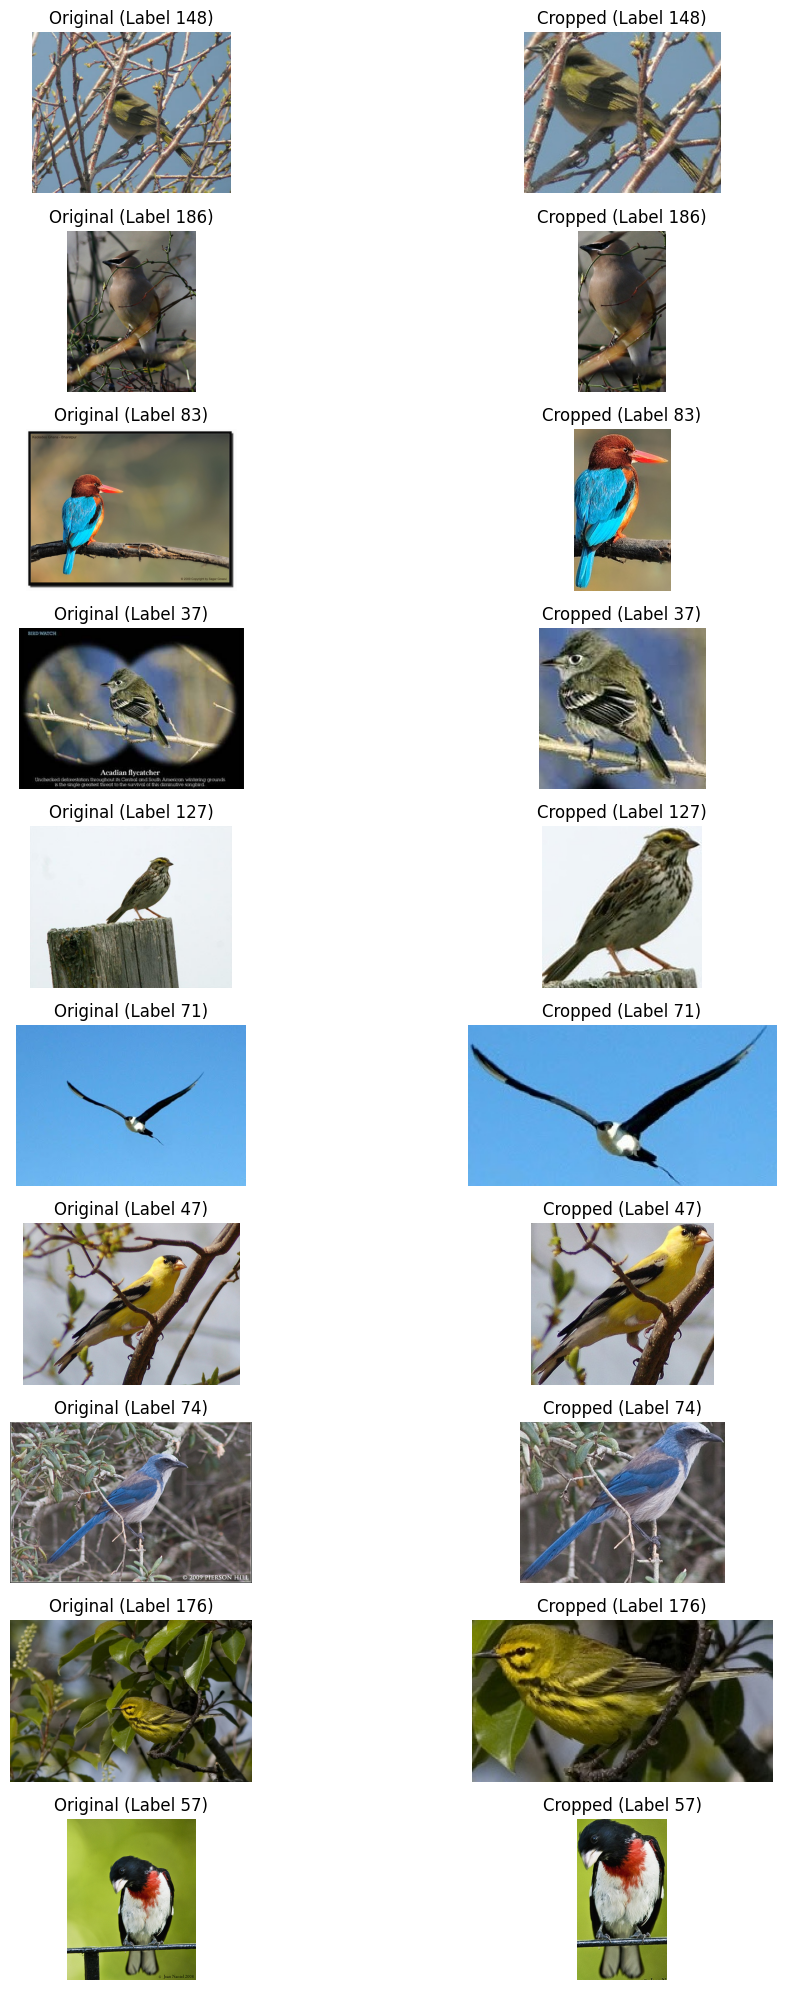

In [40]:
# Step 3: Visualization for 10 random images and their cropped versions
def visualize_crops(id_to_path, id_to_label, original_dir, cropped_dir, sample_size=10):
    sample_ids = random.sample(list(id_to_path.keys()), sample_size)
    plt.figure(figsize=(12, sample_size * 2))
    
    for i, img_id in enumerate(sample_ids):
        rel_path = id_to_path[img_id]
        label = id_to_label[img_id]

        orig_path = os.path.join(original_dir, rel_path)
        crop_path = os.path.join(cropped_dir, rel_path)

        # Read the original image
        img_orig = cv2.cvtColor(cv2.imread(orig_path), cv2.COLOR_BGR2RGB)
        img_crop = cv2.cvtColor(cv2.imread(crop_path), cv2.COLOR_BGR2RGB)

        # Plot original image
        plt.subplot(sample_size, 2, 2 * i + 1)
        plt.imshow(img_orig)
        plt.title(f"Original (Label {label})")
        plt.axis('off')

        # Plot cropped image
        plt.subplot(sample_size, 2, 2 * i + 2)
        plt.imshow(img_crop)
        plt.title(f"Cropped (Label {label})")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Call the visualization function to show 10 images with their cropped versions
visualize_crops(id_to_path, id_to_label, IMAGE_DIR, CROPPED_DIR, sample_size=10)


<p style="text-align:center;">
    <font face="Georgia" size=4 color="red"><b>Normalize ,Resize</b></font>
</p>

In [44]:
#Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

#Path to the new dataset
data_dir = '/kaggle/working/cropped__images'

# Transform for resizing and normalizing images for ResNet50
transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),  
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

# Load the dataset
full_dataset = datasets.ImageFolder(root=data_dir, transform=transform)
num_classes = len(full_dataset.classes)

# Total number of data samples
total_size = len(full_dataset)

# Split data into 80-20 ratio (train + validation)
train_val_size = int(0.8 * total_size)  
test_size = total_size - train_val_size  

# Split the dataset into train_val and test
train_val_dataset, test_dataset = random_split(full_dataset, [train_val_size, test_size])

# split train_val into train and validation 
train_size = int(0.7 * len(train_val_dataset))  
val_size = len(train_val_dataset) - train_size  

train_dataset, val_dataset = random_split(train_val_dataset, [train_size, val_size])

# DataLoader for each part of the dataset
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Display dataset information
print(f'Total Classes: {num_classes}')
print(f'Total Samples: {total_size}')
print(f'Train size: {train_size}')
print(f'Validation size: {val_size}')
print(f'Test size: {test_size}')


Using device: cuda
Total Classes: 200
Total Samples: 11788
Train size: 6601
Validation size: 2829
Test size: 2358


<p style="text-align:center;">
    <font face="Georgia" size=4 color="red"><b>Building the Bilinear CNN Model for FGIC without Attention</b></font>
</p>

In [ ]:
class BilinearCNN(nn.Module):
    def __init__(self, num_classes=200, dropout_rate=0.6):
        super(BilinearCNN, self).__init__()
        
        # Load the pre-trained ResNet50 model
        backbone = models.resnet50(pretrained=True)

        # Freeze all layers
        for param in backbone.parameters():
            param.requires_grad = False

        # Make only the last layer (layer4) trainable
        for param in backbone.layer4.parameters():
            param.requires_grad = True

        
        self.features = nn.Sequential(*list(backbone.children())[:-2])  
        # Reduce the dimension to 512
        self.reduce_dim = nn.Conv2d(2048, 512, kernel_size=1)
        # Dropout 
        self.dropout = nn.Dropout(p=dropout_rate)
        # Fully connected 
        self.fc = nn.Linear(512 * 512, num_classes)

    def forward(self, x):
        
        x = self.features(x)          
       
        x = self.reduce_dim(x)        
       
        x = x.view(x.size(0), 512, -1)  
        
        x = torch.bmm(x, x.transpose(1, 2)) / x.size(2)  
        
        x = x.view(x.size(0), -1)  
        
        x = torch.sign(x) * torch.sqrt(torch.abs(x) + 1e-10)
       
        x = nn.functional.normalize(x)
        
        x = self.dropout(x)
        
        x = self.fc(x)
        return x

# Create the model and move it to the GPU if available
model = BilinearCNN(num_classes=num_classes).to(device)

# Loss function, Optimizer, and Learning Rate Scheduler
criterion = nn.CrossEntropyLoss()  
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-3) 
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)  

# Early Stopping Class to stop training if validation loss doesn't improve
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.01):
        self.patience = patience  
        self.min_delta = min_delta  
        self.counter = 0  
        self.best_loss = None  
        self.early_stop = False  

    def __call__(self, val_loss):
        # If the current validation loss is better than the best, reset the counter
        if self.best_loss is None or val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            # If no improvement, increment the counter
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True  # Stop training if patience is exhausted

early_stopping = EarlyStopping(patience=5, min_delta=0.01)

# Training the model
num_epochs = 30
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # Validation phase
    model.eval()
    val_running_loss = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
    val_loss = val_running_loss / len(val_loader)
    val_losses.append(val_loss)

    # Print the losses for each epoch
    print(f"Epoch [{epoch+1}/{num_epochs}] → Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    # Step the learning rate scheduler
    scheduler.step(val_loss)
    # Early stopping check
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print(f"⛔ Early stopping at epoch {epoch+1}")
        break


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 226MB/s]


Epoch [1/30] → Train Loss: 4.9033 | Val Loss: 4.5497
Epoch [2/30] → Train Loss: 4.3911 | Val Loss: 4.3060
Epoch [3/30] → Train Loss: 4.1903 | Val Loss: 4.0986
Epoch [4/30] → Train Loss: 4.0208 | Val Loss: 4.0231
Epoch [5/30] → Train Loss: 3.8788 | Val Loss: 3.8325
Epoch [6/30] → Train Loss: 3.7589 | Val Loss: 3.8004
Epoch [7/30] → Train Loss: 3.6387 | Val Loss: 3.7729
Epoch [8/30] → Train Loss: 3.5152 | Val Loss: 3.6174
Epoch [9/30] → Train Loss: 3.4450 | Val Loss: 3.6278
Epoch [10/30] → Train Loss: 3.3510 | Val Loss: 3.5652
Epoch [11/30] → Train Loss: 3.2775 | Val Loss: 3.5198
Epoch [12/30] → Train Loss: 3.2205 | Val Loss: 3.4307
Epoch [13/30] → Train Loss: 3.1254 | Val Loss: 3.4913
Epoch [14/30] → Train Loss: 3.0898 | Val Loss: 3.3985
Epoch [15/30] → Train Loss: 3.0172 | Val Loss: 3.3292
Epoch [16/30] → Train Loss: 2.9719 | Val Loss: 3.3741
Epoch [17/30] → Train Loss: 2.9440 | Val Loss: 3.3513
Epoch [18/30] → Train Loss: 2.9084 | Val Loss: 3.3391
Epoch [19/30] → Train Loss: 2.7143 | 

<p style="text-align:center;">
    <font face="Georgia" size=4 color="red"><b>Selection of Evaluation Metrics</b></font>
</p>



---

### **Evaluation Metrics for CUB-200-2011:**

| **Metric**               | **Description**                                                                                         | **Why It's Useful**                                                                                                                                       |
|--------------------------|---------------------------------------------------------------------------------------------------------|---------------------------------------------------------------------------------------------------------------------------------------------------------|
| **Top-1 Accuracy**        | Checks if the **predicted class** exactly matches the **true class** of the image.                     | - Most **strict measure** for classification. <br> - Ensures correct classification, especially in **fine-grained datasets** like CUB-200.             |
| **Top-5 Accuracy**        | Checks if the **true class** is among the **top 5 predicted classes**.                                 | - Tolerant metric for **fine-grained classification** tasks. <br> - Useful for identifying **near misses** in highly similar classes.                  |
| **Confusion Matrix**      | Visualizes **true vs. predicted classes** for the entire dataset.                                        | - Helps diagnose **misclassifications**. <br> - Visualizes which classes are being confused.                                                          |
| **Balanced Accuracy**     | Calculates accuracy per class and averages, giving equal weight to all classes, regardless of frequency. | - Corrects for **class imbalance**. <br> - Ensures **fairness** by treating each class equally, preventing the model from favoring more frequent classes. |
| **Precision (Macro)**     | Proportion of correct positive predictions out of all predicted positives.                              | - Ensures the model predicts **correct positives**. <br> - Important when **false positives** matter, especially in imbalanced classes.               |
| **Recall (Macro)**        | Proportion of correct positive predictions out of all actual positives.                                | - Measures the model’s ability to **identify true positives**. <br> - Crucial when **false negatives** are costly.                                   |
| **F1-Score (Macro)**      | The harmonic mean of **Precision** and **Recall**.                                                       | - Balances **Precision** and **Recall**. <br> - Useful when both false positives and false negatives need to be minimized, especially in imbalanced data. |
| **Weighted F1-Score**     | Computes the F1-Score for each class and weights it according to the class frequency.                    | - Adjusts for **class frequency** by giving more importance to **frequent classes**. <br> - Useful when focusing on overall performance, not just rare classes. |

---

### **Summary**:

| **Metric**               | **Purpose**                                                                         |
|--------------------------|-------------------------------------------------------------------------------------|
| **Top-1 Accuracy**        | Strict measure of exact class prediction.                                           |
| **Top-5 Accuracy**        | Allows for minor errors, useful for fine-grained tasks.                             |
| **Confusion Matrix**      | Visualizes per-class performance and misclassifications.                            |
| **Balanced Accuracy**     | Corrects for class imbalance by averaging accuracy across all classes.              |
| **Precision, Recall, F1 (Macro)** | Detailed performance evaluation across all classes, balancing false positives and negatives. |
| **Weighted F1-Score**     | Balances class frequencies and overall performance by weighing F1-Score based on class frequency. |

---



<p style="text-align:center;">
    <font face="Georgia" size=4 color="red"><b>Model Evaluation</b></font>
</p>


 Performance on Validation Set:
Accuracy:  0.3054
Top-5 Accuracy:  0.7759
Precision: 0.2463
Recall:    0.3299
F1-Score:  0.2446
Balanced Accuracy: 0.3054


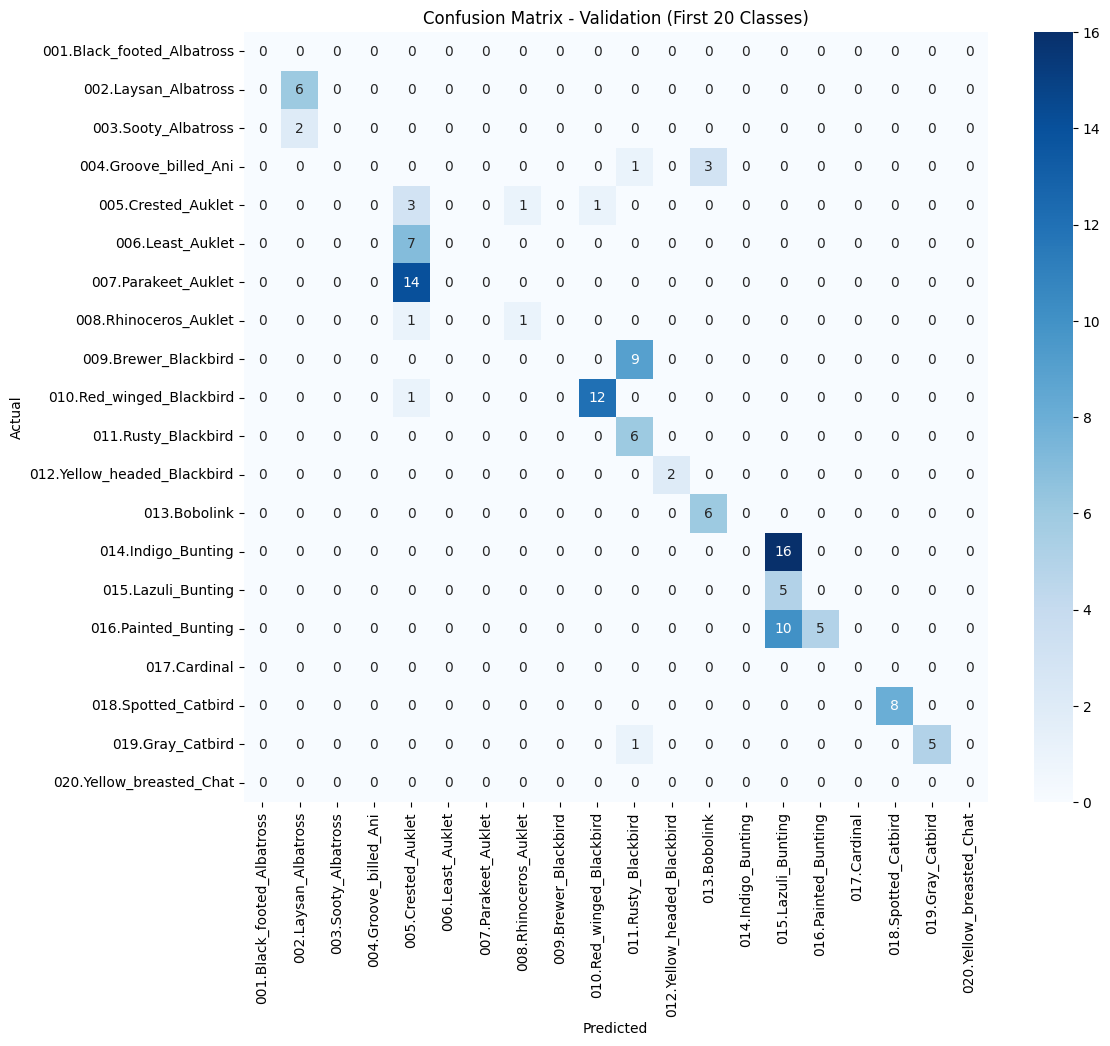


 Performance on Test Set:
Accuracy:  0.2897
Top-5 Accuracy:  0.7629
Precision: 0.2457
Recall:    0.3255
F1-Score:  0.2380
Balanced Accuracy: 0.2897


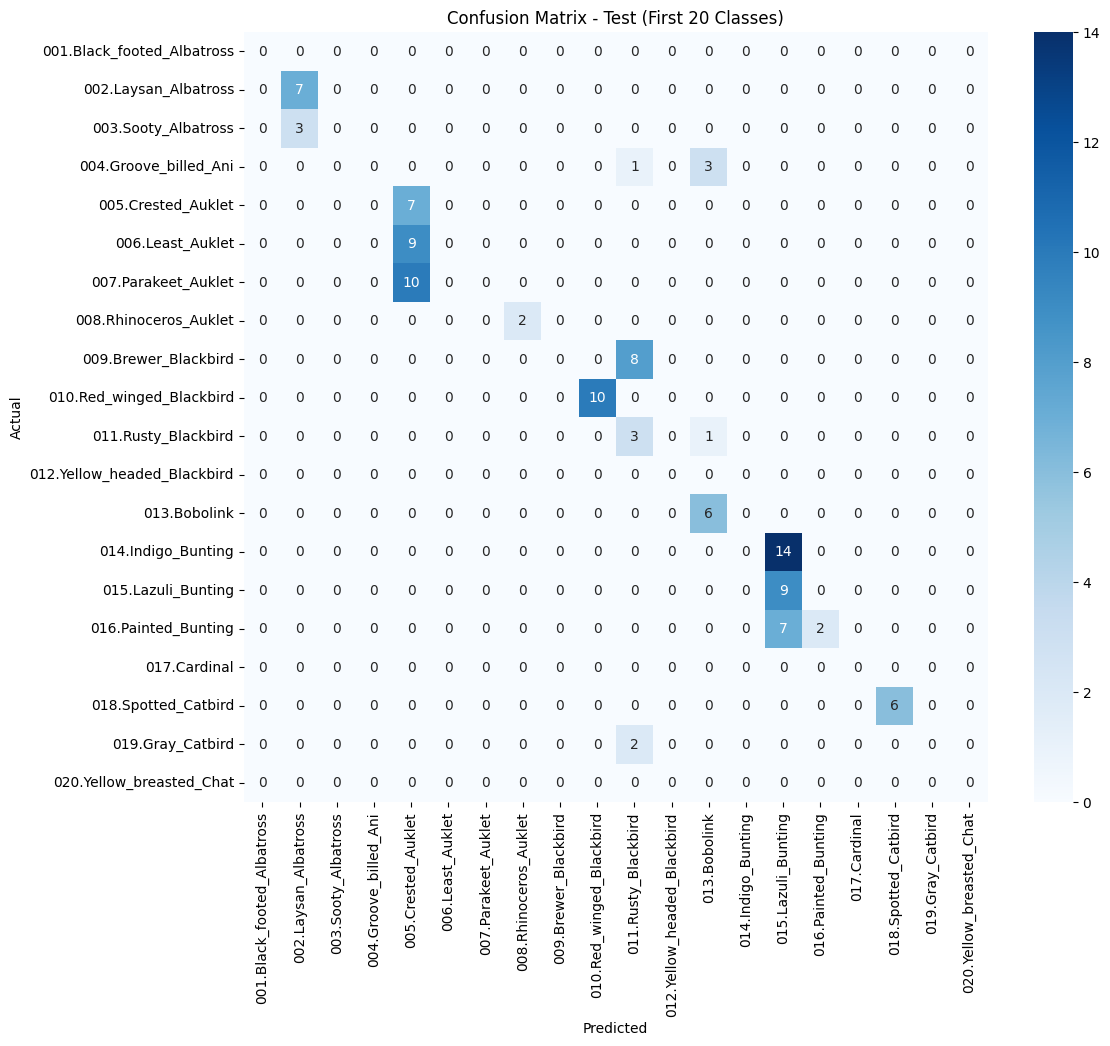

In [47]:
def evaluate_model(model, dataloader, dataset_name):
    model.eval()  
    all_preds = [] 
    all_labels = []  
    top5_preds = []  

    with torch.no_grad():  
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)  
            outputs = model(images)  
            _, preds = torch.max(outputs, 1)  

            # For Top-5 Accuracy
            _, top5 = torch.topk(outputs, 5, dim=1, largest=True, sorted=True)  

            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            top5_preds.extend(top5.cpu().numpy())

    #Calculate Metrics
    acc = accuracy_score(all_labels, all_preds) 
    precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)  
    recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)  
    f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)  
    
    # Calculate Top-5 Accuracy
    top5_acc = np.mean([1 if lbl in top5 else 0 for lbl, top5 in zip(all_labels, top5_preds)])

    # Calculate Balanced Accuracy 
    balanced_acc = np.mean([accuracy_score([lbl], [lbl_pred]) for lbl, lbl_pred in zip(all_labels, all_preds)])

    # Print performance metrics
    print(f"\n Performance on {dataset_name} Set:")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Top-5 Accuracy:  {top5_acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    print(f"Balanced Accuracy: {balanced_acc:.4f}")

    # Display confusion matrix for the first 20 classes
    cm = confusion_matrix(all_labels, all_preds)  
    plt.figure(figsize=(12, 10)) 
    sns.heatmap(cm[:20, :20], annot=True, fmt='d', cmap='Blues',  
                xticklabels=full_dataset.classes[:20],
                yticklabels=full_dataset.classes[:20])
    plt.title(f"Confusion Matrix - {dataset_name} (First 20 Classes)")  
    plt.xlabel("Predicted")  
    plt.ylabel("Actual")  
    plt.show()  

# Evaluate on the Validation set
evaluate_model(model, val_loader, "Validation")

# Evaluate on the Test set
evaluate_model(model, test_loader, "Test")


<p style="text-align:center;">
    <font face="Georgia" size=4 color="red"><b>Class to Class Report</b></font>
</p>

In [49]:
def evaluate_metrics_summary(model, dataloader, dataset_name):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    
    print(f"\Detailed Classification Report on {dataset_name} Set:")
    print(classification_report(all_labels, all_preds, target_names=full_dataset.classes, digits=3))


In [50]:


evaluate_metrics_summary(model, val_loader, "Validation")

evaluate_metrics_summary(model, test_loader, "Test")


\Detailed Classification Report on Validation Set:
                                    precision    recall  f1-score   support

        001.Black_footed_Albatross      0.000     0.000     0.000        16
              002.Laysan_Albatross      0.261     0.600     0.364        10
               003.Sooty_Albatross      0.000     0.000     0.000        12
             004.Groove_billed_Ani      0.000     0.000     0.000        20
                005.Crested_Auklet      0.107     0.500     0.176         6
                  006.Least_Auklet      0.000     0.000     0.000         7
               007.Parakeet_Auklet      0.000     0.000     0.000        14
             008.Rhinoceros_Auklet      0.500     0.111     0.182         9
              009.Brewer_Blackbird      0.000     0.000     0.000        12
          010.Red_winged_Blackbird      0.750     0.706     0.727        17
               011.Rusty_Blackbird      0.146     0.500     0.226        12
       012.Yellow_headed_Blackbird  

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


\Detailed Classification Report on Test Set:
                                    precision    recall  f1-score   support

        001.Black_footed_Albatross      0.000     0.000     0.000        13
              002.Laysan_Albatross      0.333     0.700     0.452        10
               003.Sooty_Albatross      0.000     0.000     0.000        13
             004.Groove_billed_Ani      0.000     0.000     0.000        13
                005.Crested_Auklet      0.259     1.000     0.412         7
                  006.Least_Auklet      0.000     0.000     0.000         9
               007.Parakeet_Auklet      0.000     0.000     0.000        11
             008.Rhinoceros_Auklet      0.667     0.250     0.364         8
              009.Brewer_Blackbird      0.000     0.000     0.000        14
          010.Red_winged_Blackbird      0.909     0.769     0.833        13
               011.Rusty_Blackbird      0.100     0.273     0.146        11
       012.Yellow_headed_Blackbird      0.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<p style="text-align:center;">
    <font face="Georgia" size=4 color="red"><b>Show Predictions</b></font>
</p>

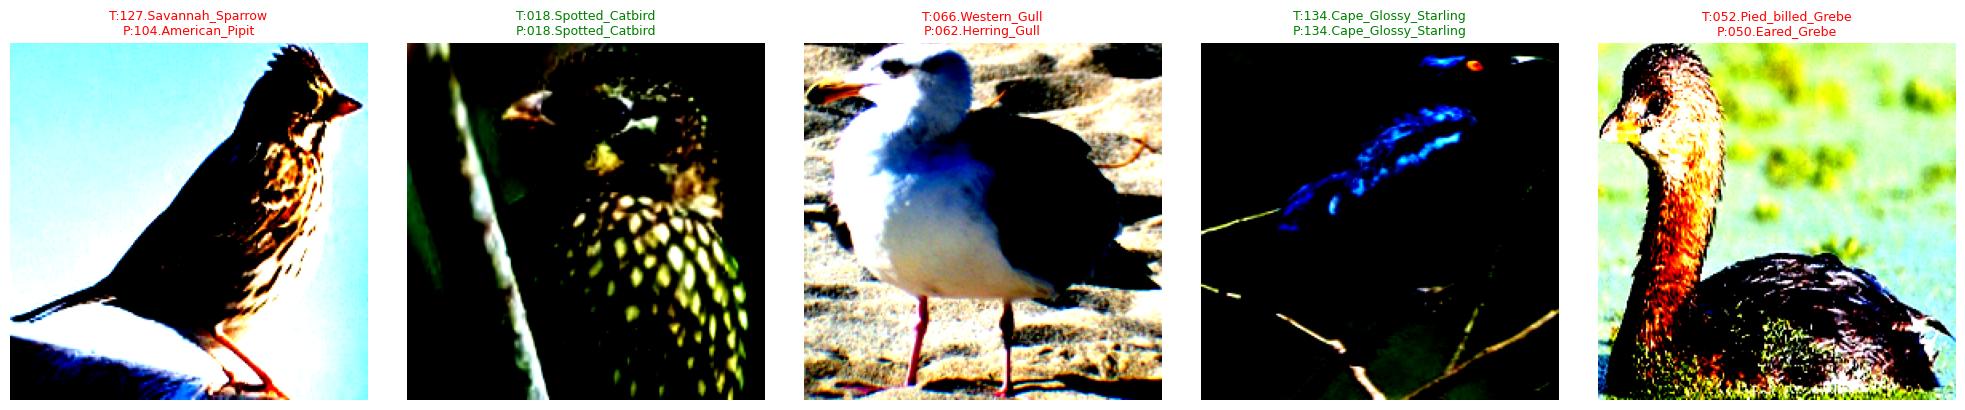

In [ ]:
import random
import matplotlib.pyplot as plt

def show_random_predictions(model, dataset, class_names, device, num_images=10):
    model.eval()
    indices = random.sample(range(len(dataset)), num_images)
    fig, axes = plt.subplots(1, num_images, figsize=(20, 4))

    for i, idx in enumerate(indices):
        image, label = dataset[idx]
        input_img = image.unsqueeze(0).to(device)
        with torch.no_grad():
            output = model(input_img)
            _, pred = torch.max(output, 1)

        true_label = class_names[label]
        predicted_label = class_names[pred.item()]

        color = 'green' if pred.item() == label else 'red'

        axes[i].imshow(image.permute(1, 2, 0).cpu().numpy())
        axes[i].set_title(f"T:{true_label}\nP:{predicted_label}", color=color, fontsize=9)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()


class_names = full_dataset.classes
show_random_predictions(model, test_loader, class_names, device, num_images=5)



<p style="text-align:center;">
    <font face="Georgia" size=4 color="red"><b>Building the Bilinear CNN Model for FGIC with Attention</b></font>
</p>

In [ ]:
# Self-Attention Model
class SelfAttention(nn.Module):
    def __init__(self, in_channels):
        super(SelfAttention, self).__init__()
        
        self.query = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)
        self.key = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)
        self.value = nn.Conv2d(in_channels, in_channels, kernel_size=1)

    def forward(self, x):
        batch_size, channels, height, width = x.size()
        
        # Compute the query, key, and value tensors
        query = self.query(x).view(batch_size, -1, height * width) 
        key = self.key(x).view(batch_size, -1, height * width)  
        value = self.value(x).view(batch_size, -1, height * width)  

        # Compute the attention map
        attention = torch.matmul(query, key.transpose(1, 2))  
        attention = torch.softmax(attention, dim=-1) 

        
        out = torch.matmul(attention, value)  
        out = out.view(batch_size, channels, height, width)  
        return out

# Bilinear CNN with Attention Model
class BilinearCNNWithAttention(nn.Module):
    def __init__(self, num_classes=200, dropout_rate=0.6):
        super(BilinearCNNWithAttention, self).__init__()
        backbone = models.resnet50(pretrained=True)

        # Freeze all layers
        for param in backbone.parameters():
            param.requires_grad = False

        # Make only the last layer (layer4) trainable
        for param in backbone.layer4.parameters():
            param.requires_grad = True

        # Extract features from the pre-trained ResNet50 backbone, excluding avgpool and fc layers
        self.features = nn.Sequential(*list(backbone.children())[:-2])
        self.attention = SelfAttention(in_channels=2048)  
        self.reduce_dim = nn.Conv2d(2048, 512, kernel_size=1) 
        self.dropout = nn.Dropout(p=dropout_rate)  
        self.fc = nn.Linear(512 * 512, num_classes)  
    def forward(self, x):
        
        x = self.features(x)           
        x = self.attention(x)          
        x = self.reduce_dim(x)         
        x = x.view(x.size(0), 512, -1) 
        x = torch.bmm(x, x.transpose(1, 2)) / x.size(2) 
        x = x.view(x.size(0), -1)      
        x = torch.sign(x) * torch.sqrt(torch.abs(x) + 1e-10)  
        x = nn.functional.normalize(x)  
        x = self.dropout(x)  
        x = self.fc(x)  
        return x

# New model with Attention
model_attention = BilinearCNNWithAttention(num_classes=num_classes).to(device)

#  Loss function, Optimizer, and Scheduler
criterion = nn.CrossEntropyLoss()  
optimizer = optim.Adam(model_attention.parameters(), lr=1e-4, weight_decay=1e-3)  
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)  

# Early Stopping Class
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.01):
        self.patience = patience  
        self.min_delta = min_delta  
        self.counter = 0 
        self.best_loss = None  
        self.early_stop = False  

    def __call__(self, val_loss):
        
        if self.best_loss is None or val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True  

early_stopping = EarlyStopping(patience=5, min_delta=0.01)

#Training the model with Attention
train_losses, val_losses = [], []
num_epochs = 30
for epoch in range(num_epochs):
    model_attention.train()  
    running_loss = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model_attention(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # Validation loop
    model_attention.eval()  
    val_running_loss = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model_attention(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
    val_loss = val_running_loss / len(val_loader)
    val_losses.append(val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}] → Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    # Step the learning 
    scheduler.step(val_loss)
    # Early stopping check
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print(f"Early stopping at epoch {epoch+1}")
        break


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 168MB/s] 


Epoch [1/30] → Train Loss: 5.2849 | Val Loss: 5.2593
Epoch [2/30] → Train Loss: 5.2124 | Val Loss: 5.1625
Epoch [3/30] → Train Loss: 5.0979 | Val Loss: 5.0440
Epoch [4/30] → Train Loss: 4.9681 | Val Loss: 4.9211
Epoch [5/30] → Train Loss: 4.8347 | Val Loss: 4.8004
Epoch [6/30] → Train Loss: 4.7014 | Val Loss: 4.6840
Epoch [7/30] → Train Loss: 4.5699 | Val Loss: 4.5725
Epoch [8/30] → Train Loss: 4.4423 | Val Loss: 4.4661
Epoch [9/30] → Train Loss: 4.3213 | Val Loss: 4.3688
Epoch [10/30] → Train Loss: 4.2035 | Val Loss: 4.2693
Epoch [11/30] → Train Loss: 4.0920 | Val Loss: 4.1812
Epoch [12/30] → Train Loss: 3.9856 | Val Loss: 4.0929
Epoch [13/30] → Train Loss: 3.8861 | Val Loss: 4.0229
Epoch [14/30] → Train Loss: 3.7918 | Val Loss: 3.9410
Epoch [15/30] → Train Loss: 3.7015 | Val Loss: 3.8692
Epoch [16/30] → Train Loss: 3.6172 | Val Loss: 3.8050
Epoch [17/30] → Train Loss: 3.5375 | Val Loss: 3.7407
Epoch [18/30] → Train Loss: 3.4620 | Val Loss: 3.6860
Epoch [19/30] → Train Loss: 3.3930 | 

<p style="text-align:center;">
    <font face="Georgia" size=4 color="red"><b>Model Evaluation</b></font>
</p>


Performance on Validation Set:
Accuracy:  0.4514
Top-5 Accuracy:  0.8636
Precision: 0.4633
Recall:    0.4683
F1-Score:  0.4063
Balanced Accuracy: 0.4514


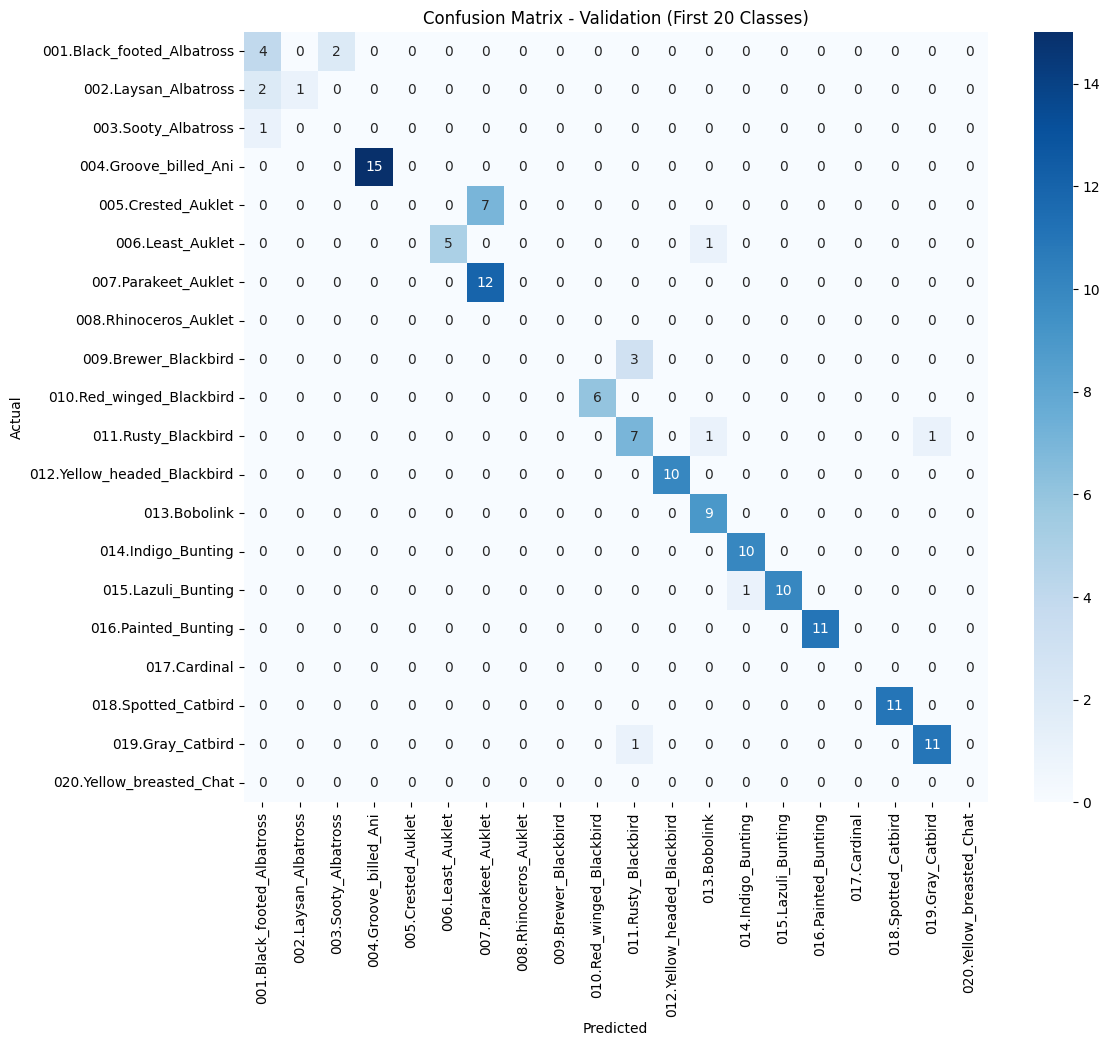


Performance on Test Set:
Accuracy:  0.4313
Top-5 Accuracy:  0.8588
Precision: 0.4355
Recall:    0.4620
F1-Score:  0.3926
Balanced Accuracy: 0.4313


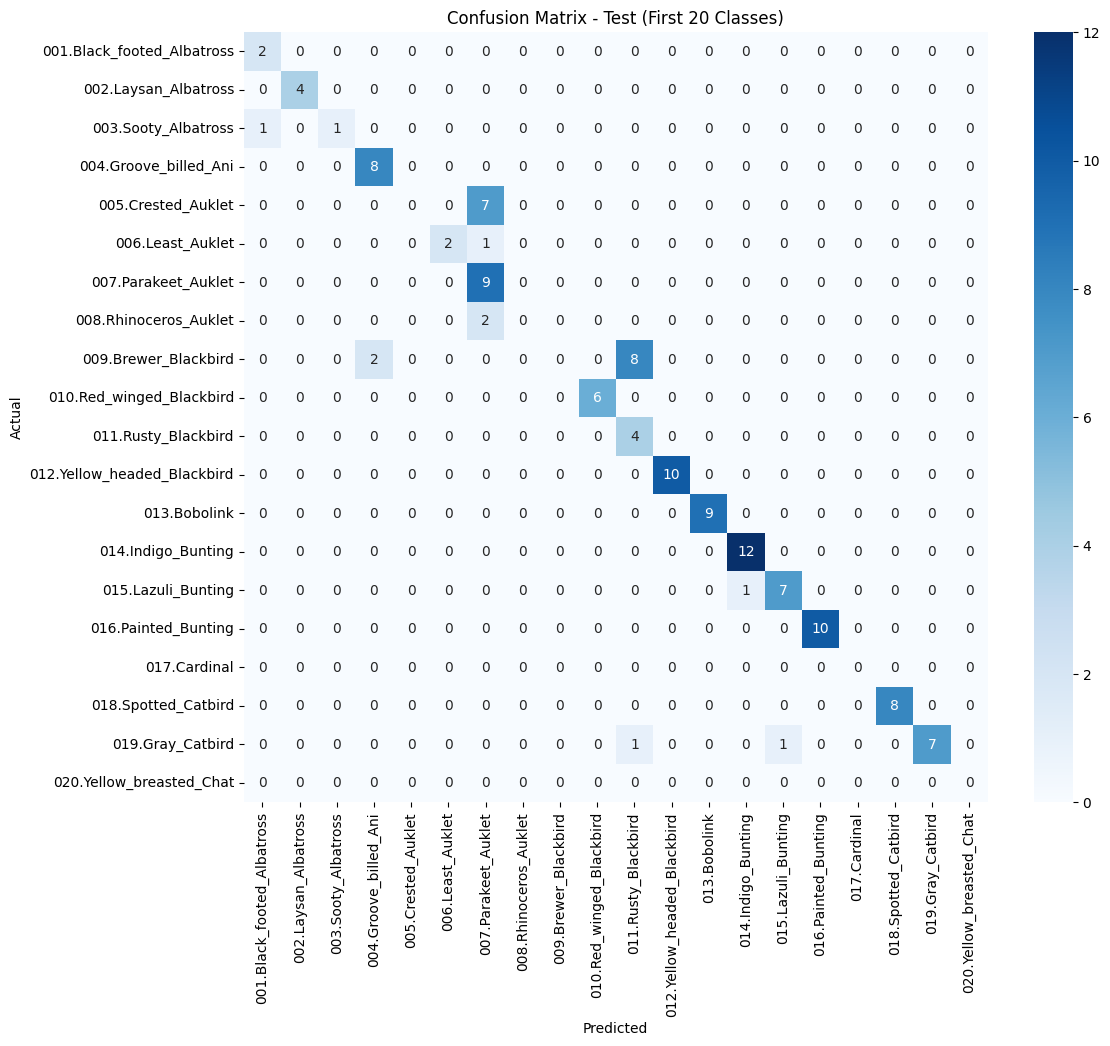

In [6]:
# Function to evaluate the model performance
def evaluate_model(model, dataloader, dataset_name):
    model.eval()  
    
    # Lists to store all predictions, true labels, and top-5 predictions
    all_preds = []
    all_labels = []
    top5_preds = []

    with torch.no_grad():  
        # Loop through the dataloader to get batches of images and labels
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)  
            outputs = model(images)  
            _, preds = torch.max(outputs, 1)  

            # For Top-5 Accuracy
            _, top5 = torch.topk(outputs, 5, dim=1, largest=True, sorted=True)  

            # Store the predictions, true labels, and top 5 predictions
            all_preds.extend(preds.cpu().numpy()) 
            all_labels.extend(labels.cpu().numpy())
            top5_preds.extend(top5.cpu().numpy())

    # Calculate performance metrics
    acc = accuracy_score(all_labels, all_preds)  
    precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)  
    recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)  
    f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)  
    
    # Calculate Top-5 Accuracy
    top5_acc = np.mean([1 if lbl in top5 else 0 for lbl, top5 in zip(all_labels, top5_preds)])

    # Calculate Balanced Accuracy 
    balanced_acc = np.mean([accuracy_score([lbl], [lbl_pred]) for lbl, lbl_pred in zip(all_labels, all_preds)])

    # Print out the performance metrics
    print(f"\nPerformance on {dataset_name} Set:")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Top-5 Accuracy:  {top5_acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    print(f"Balanced Accuracy: {balanced_acc:.4f}")

    # Display confusion matrix for the first 20 classes
    cm = confusion_matrix(all_labels, all_preds)  
    plt.figure(figsize=(12, 10))  
    sns.heatmap(cm[:20, :20], annot=True, fmt='d', cmap='Blues',  
                xticklabels=full_dataset.classes[:20], 
                yticklabels=full_dataset.classes[:20])  
    plt.title(f"Confusion Matrix - {dataset_name} (First 20 Classes)")  
    plt.xlabel("Predicted")  
    plt.ylabel("Actual")  
    plt.show()  

# Evaluate on the Validation set
evaluate_model(model_attention, val_loader, "Validation")

# Evaluate on the Test set
evaluate_model(model_attention, test_loader, "Test")


<p style="text-align:center;">
    <font face="Georgia" size=4 color="red"><b>Show Predictions</b></font>
</p>

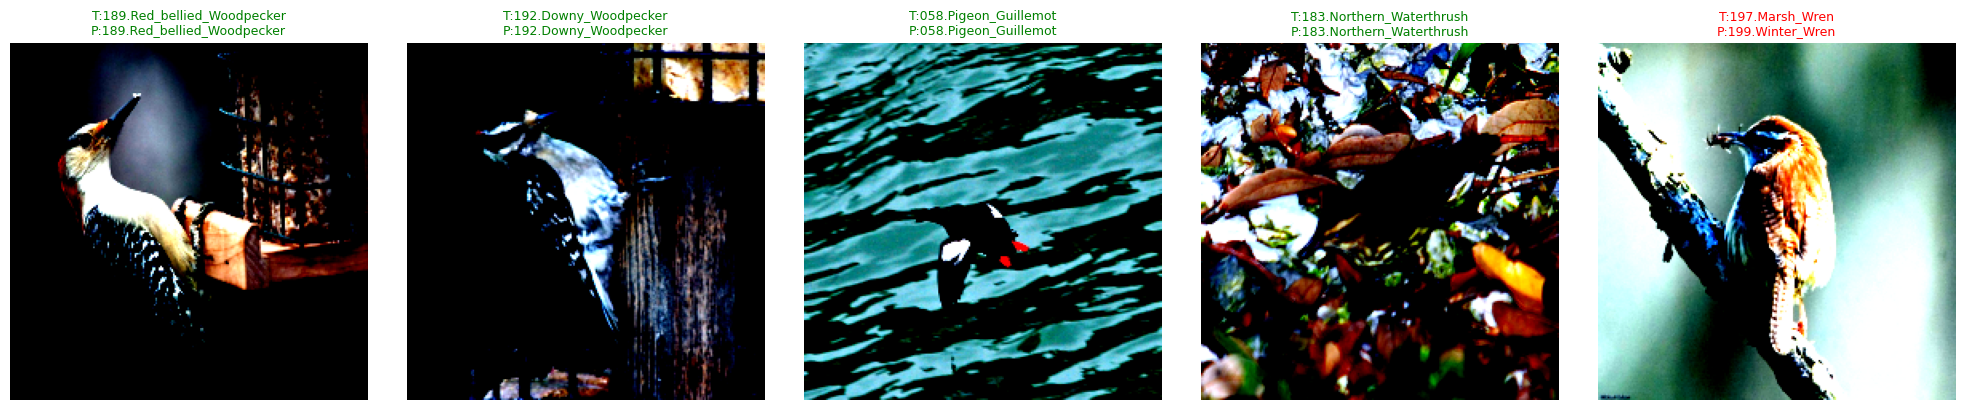

In [ ]:
def show_random_predictions(model, dataset, class_names, device, num_images=10):
    model.eval()
    indices = random.sample(range(len(dataset)), num_images)
    fig, axes = plt.subplots(1, num_images, figsize=(20, 4))

    for i, idx in enumerate(indices):
        image, label = dataset[idx]
        input_img = image.unsqueeze(0).to(device)
        with torch.no_grad():
            output = model(input_img)
            _, pred = torch.max(output, 1)

        true_label = class_names[label]
        predicted_label = class_names[pred.item()]

        color = 'green' if pred.item() == label else 'red'

        axes[i].imshow(image.permute(1, 2, 0).cpu().numpy())
        axes[i].set_title(f"T:{true_label}\nP:{predicted_label}", color=color, fontsize=9)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

class_names = full_dataset.classes

show_random_predictions(model_attention, test_loader, class_names, device, num_images=5)


<p style="text-align:center;">
    <font face="Georgia" size=4 color="red"><b>Model Performance Comparison</b></font>
</p>



---

### **Model Performance Comparison**:

| **Metric**               | **Without Attention**    | **With Attention**       |
|--------------------------|--------------------------|--------------------------|
| **Accuracy**              | 0.3054                   | 0.4514                   |
| **Top-5 Accuracy**        | 0.7759                   | 0.8636                   |
| **Precision**             | 0.2463                   | 0.4633                   |
| **Recall**                | 0.3299                   | 0.4683                   |
| **F1-Score**              | 0.2446                   | 0.4063                   |
| **Balanced Accuracy**     | 0.3054                   | 0.4514                   |

---

### **Analysis of the Results**:

1. **Accuracy**:
   - **Without Attention**: The accuracy is 0.3054, which is a moderate result indicating the model is able to predict the correct class with about 30% accuracy on both the validation and test sets.
   - **With Attention**: The accuracy increases significantly to 0.4514. This shows a notable improvement due to the introduction of the attention mechanism, which helps the model focus on the most important parts of the input images.

2. **Top-5 Accuracy**:
   - **Without Attention**: The Top-5 Accuracy is 0.7759, meaning that the true class is in the top 5 predictions 77.59% of the time.
   - **With Attention**: This value increases to 0.8636, indicating that the attention mechanism allows the model to make better predictions, with the true class appearing in the top 5 predictions more frequently (86.36%).

3. **Precision**:
   - **Without Attention**: The precision is 0.2463, which means that when the model predicts a class, only 24.63% of those predictions are correct.
   - **With Attention**: The precision improves to 0.4633, showing a much better ability to make accurate positive predictions due to the attention mechanism.

4. **Recall**:
   - **Without Attention**: The recall is 0.3299, meaning that the model correctly identifies 32.99% of the true positive cases in the dataset.
   - **With Attention**: The recall improves to 0.4683, which is a significant increase, showing that the model is now able to correctly identify more positive cases due to better focus on relevant features through attention.

5. **F1-Score**:
   - **Without Attention**: The F1-Score is 0.2446, which is a harmonic mean of precision and recall, indicating a poor balance between these two metrics.
   - **With Attention**: The F1-Score improves to 0.4063, showing a better balance between precision and recall with the attention mechanism in place.

6. **Balanced Accuracy**:
   - **Without Attention**: The balanced accuracy is 0.3054, which indicates a relatively low ability to classify minority classes in a balanced way.
   - **With Attention**: The balanced accuracy improves to 0.4514, which demonstrates that the attention mechanism not only improves overall accuracy but also helps with the performance on minority classes.

---

### **Conclusion**:

- **With Attention**: The model performs much better across all metrics when the attention mechanism is applied. The improvements in **accuracy**, **precision**, **recall**, **F1-Score**, and **balanced accuracy** indicate that the attention mechanism helps the model focus on more relevant features of the input, leading to better classification results.
  
- **Without Attention**: The results are significantly lower, showing that while the model is able to perform reasonably well, it struggles with fine-grained tasks where attention to important features is crucial.


In [ ]:
# Sahar Abdi